# Extreme Gradient Boosting Classifier

By Steven Sison on December 16, 2023

## Description

This document will be used for the preliminary training and evaluation of the extreme gradient boosting classifier. The document includes the necessary processes taken to train the model with the default hyperparameters. This also evaluates the performance of the classifier in terms of accuracy, precision, recall, F1-score, training time, and detection time. Furthermore, this document will only use lexical features and will observe the effect of increasing the number of features used in the model. As this is only for preliminary work, no optimizations, except a simple train-test validation, will be carried out.

### Preliminaries

In [20]:
import pandas as pd                     # For data transformation
import numpy as numpy                   # For scientific calculations
import seaborn as sns                   # For data visualizations
import matplotlib.pyplot as plt         # For plotting
import plotly.graph_objects as go       # For plotting
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import time
from datetime import datetime

dataset = pd.read_csv("temp_unbalanced_withFeatures.csv")      # Loading the dataset
x_train, x_test, y_train, y_test = train_test_split(dataset.drop(columns=['url_type']), dataset['url_type'], test_size = 0.2, random_state=42)

## Model Training and Evaluation

### Base Model using All Lexical Features Generated

In [21]:
pipeline = Pipeline([
    ('classifier', XGBClassifier())
])

pipeline.fit(x_train, y_train)

# pipeline = XGBClassifier()
pipeline.fit(x_train, y_train)

Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [22]:
y_pred = pipeline.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     85560
           1       0.88      0.88      0.88     18804
           2       0.79      0.75      0.77     27061
           3       0.96      0.81      0.88      5412

    accuracy                           0.90    136837
   macro avg       0.89      0.85      0.87    136837
weighted avg       0.90      0.90      0.90    136837



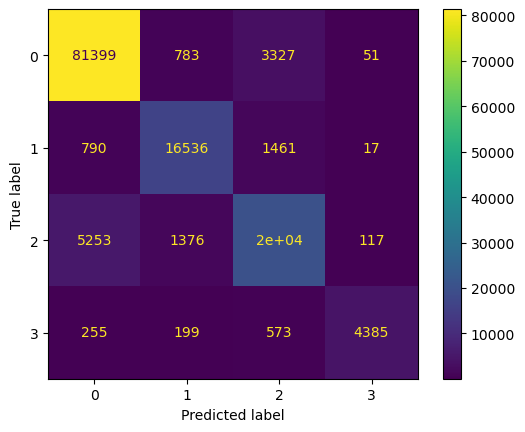

In [23]:
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = pipeline.classes_)
disp.plot()
plt.show()

### Evaluating the Effect of Balanced and Unbalanced Datasets

In [24]:
dataset['url_type'].value_counts()

url_type
0    428080
2    134094
1     95308
3     26700
Name: count, dtype: int64

In [25]:
# Upsampling

from sklearn.utils import resample

dataset_benign = dataset[(dataset['url_type'] == 0)]
dataset_defacement = dataset[(dataset['url_type'] == 1)]
dataset_phishing = dataset[(dataset['url_type'] == 2)]
dataset_malware = dataset[(dataset['url_type'] == 3)]

dataset_defacement_upsampled = resample(dataset_defacement,
                                        replace=True,
                                        n_samples = dataset_malware.shape[0],
                                        random_state = 15)

dataset_phishing_upsampled = resample(dataset_phishing,
                                        replace=True,
                                        n_samples = dataset_malware.shape[0],
                                        random_state = 15)

dataset_malware_upsampled = resample(dataset_malware,
                                        replace=True,
                                        n_samples = dataset_malware.shape[0],
                                        random_state = 15)

dataset_benign_upsampled = resample(dataset_benign,
                                        replace=True,
                                        n_samples = dataset_malware.shape[0],
                                        random_state = 15)

dataset_upsampled = pd.concat([dataset_benign_upsampled, dataset_defacement_upsampled, dataset_malware_upsampled, dataset_phishing_upsampled])

# dataset_upsampled.info(0)
dataset_upsampled['url_type'].value_counts()

url_type
0    26700
1    26700
3    26700
2    26700
Name: count, dtype: int64

In [26]:
x_up_train, x_up_test, y_up_train, y_up_test = train_test_split(dataset_upsampled.drop(columns=['url_type']), dataset_upsampled['url_type'], test_size = 0.2, random_state=42)

pipeline_up = Pipeline([
    ('classifier', XGBClassifier())
])

pipeline_up.fit(x_up_train, y_up_train)
y_up_pred = pipeline_up.predict(x_up_test)
print(classification_report(y_up_test, y_up_pred))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      5367
           1       0.88      0.93      0.90      5430
           2       0.78      0.81      0.79      5175
           3       0.95      0.89      0.92      5388

    accuracy                           0.87     21360
   macro avg       0.87      0.87      0.87     21360
weighted avg       0.88      0.87      0.87     21360



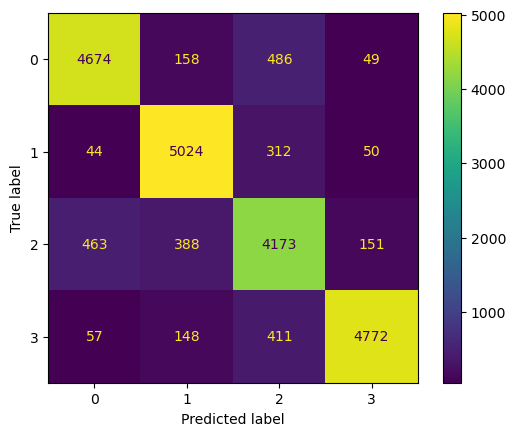

In [27]:
cm_up = confusion_matrix(y_up_test, y_up_pred, labels=pipeline_up.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm_up, display_labels = pipeline_up.classes_)
disp.plot()
plt.show()

### Evaluating the Effect of Adding more Lexical Features

In [28]:
def get_numerical_values(url):
    url = url.replace('www.', '')
    
    return {
        'url_length': get_url_length(url),
        'letter_count': count_letters(url),
        'digits_count': count_digits(url),
        'special_chars_count': count_special_chars(url),
        '._count' : get_char_count(url,'.'),
        '-_count' : get_char_count(url,'-'),
        '__count' : get_char_count(url,'_'),
        '=_count' : get_char_count(url,'='),
        '/_count' : get_char_count(url,'/'),
        '?_count' : get_char_count(url,'?'),
        ';_count' : get_char_count(url,';'),
        '(_count' : get_char_count(url,'('),
        ')_count' : get_char_count(url,')'),
        '%_count' : get_char_count(url,'%'),
        '&_count' : get_char_count(url,'&'),
        '@_count' : get_char_count(url,'@')
    }

def get_url_length(url):
    return len(url)
def count_letters(url):
    num_letters = sum(char.isalpha() for char in url)
    return num_letters

def count_digits(url):
    num_digits = sum(char.isdigit() for char in url)
    return num_digits
def count_special_chars(url):
    special_chars = "!@#$%^&*()_+-=[]{};:,.<>/?`~|"
    num_special_chars = sum(char in special_chars for char in url)
    return num_special_chars
def get_char_count(url, char):
    """
    Takes an input string url and string char and returns the number of times (in int) the input char is seen in the url.
    """
    count = 0
    for i in url:
        if i == char:
            count += 1
    return(count)

In [29]:
results = []

for i in range(4):
    pipeline = Pipeline([('classifier', XGBClassifier())])

    temp_url_features = x_train.iloc[:, 0:(4*(i+1))]
    
    pipeline.fit(temp_url_features, y_train)
    
    url_type_predict = pipeline.predict(x_test.iloc[:, 0:(4*(i+1))])

    start = time.perf_counter()

    numerical_values = get_numerical_values('https://www.freecodecamp.org/news/python-get-current-directory/')
    num_values = list(numerical_values.values())
    num_values = num_values[0:(4*(i+1))]
    pipeline.predict([list(num_values)])

    end = time.perf_counter()

    prediction_time = end-start

    accuracy = accuracy_score(y_test, url_type_predict)
    recall = recall_score(y_test, url_type_predict, average = 'weighted')
    precision = precision_score(y_test, url_type_predict, average = 'weighted', zero_division=1)
    f1 = f1_score(y_test, url_type_predict, average = 'weighted')
    results.append(((4*(i+1)), accuracy, recall, precision, f1, prediction_time))

In [30]:
results = pd.DataFrame(results, columns=['Number of Features', 'Accuracy', 'Recall', 'Precision', 'F1-Score', 'Score Time'])
results = results.sort_values(by='Number of Features', ascending=True)
print(results)

   Number of Features  Accuracy    Recall  Precision  F1-Score  Score Time
0                   4  0.777275  0.777275   0.774274  0.763630    0.001147
1                   8  0.870028  0.870028   0.868060  0.868079    0.001127
2                  12  0.892902  0.892902   0.891616  0.891806    0.000975
3                  16  0.896212  0.896212   0.895054  0.895189    0.000831


Observations:
- Increasing the number of features improves all the class weighted metrics of the model at the cost of a higher training time.